In [2]:
## Import packages 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
## Importing the csv into a dataframe 
nba_df = pd.read_csv('/Users/krist/Downloads/nba_df.csv')
nba_df.head()

,Season,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Position
0,2003,Tariq Abdul-Wahad,SG,28,DAL,14,0,14.6,1.9,4.1,...,NaN,0.2,0.2,0.4,0.104,-1.6,0.2,-1.4,0.0,SG
1,2003,Shareef Abdur-Rahim,PF,26,ATL,81,81,38.1,7.0,14.6,...,NaN,7.4,2.3,9.7,0.151,2.3,-0.7,1.6,2.8,PF
2,2003,Courtney Alexander,PG,25,NOH,66,7,20.6,2.9,7.7,...,NaN,0.1,1.0,1.1,0.040,-3.3,-1.2,-4.5,-0.9,PG
3,2003,Malik Allen,PF,24,MIA,80,73,29.0,4.2,9.9,...,NaN,-1.7,2.6,0.9,0.018,-3.9,-0.4,-4.4,-1.4,PF
4,2003,Ray Allen*,SG,27,TOT,76,75,37.9,7.9,17.9,...,NaN,7.6,1.5,9.1,0.152,4.7,-1.0,3.6,4.1,SG


In [4]:
position_array = pd.unique(nba_df['Pos'])

# Counting the number of players who have had at least one season registered under two different positions 
# finding the positions that we want to filter the dataset for: 
multi_pos = []
for i in position_array: 
    if i.find('-') != -1:
        multi_pos.append(i)
                
weird_pos = nba_df[nba_df['Pos'].isin(multi_pos)].groupby('Pos')['Player'].count().sort_values(ascending=False)
weird_pos = weird_pos.index[:]

# We want to get the player names in order to then change their position to a single one
#positions = pd.DataFrame(nba_df[nba_df['Pos'].isin(weird_pos)].Pos.values)
#positions['Old'] = positions[0]
#positions['New'] = positions.apply(lambda x: x['Old'][:x['Old'].find('-')] ,axis=1)
#positions=positions.drop(labels=0, axis=1)


# Algorithm to change the position of a player who lists multiple positions. The logic is to set the player's position to the 
# leftmost one in his position.
nba_df['Position'] = nba_df.apply(lambda x: x['Pos'][:x['Pos'].find('-')] if x['Pos'] in weird_pos else x['Pos'], axis=1)
nba_df_final = nba_df.drop(labels='Pos',axis=1)

## We want to turn the percentage statistics into numbers in order to have better scaling when we deploy visualizations
nba_df_final.columns
cols = nba_df_final[['FG%','3P%','2P%','eFG%','FT%','TS%']].columns.values

# Iterate through the desired columns to change each to numeric 
nba_df_final[cols] = nba_df_final[cols].apply(pd.to_numeric)
nba_df_final[cols] = nba_df_final[cols].apply(lambda x: x*100)

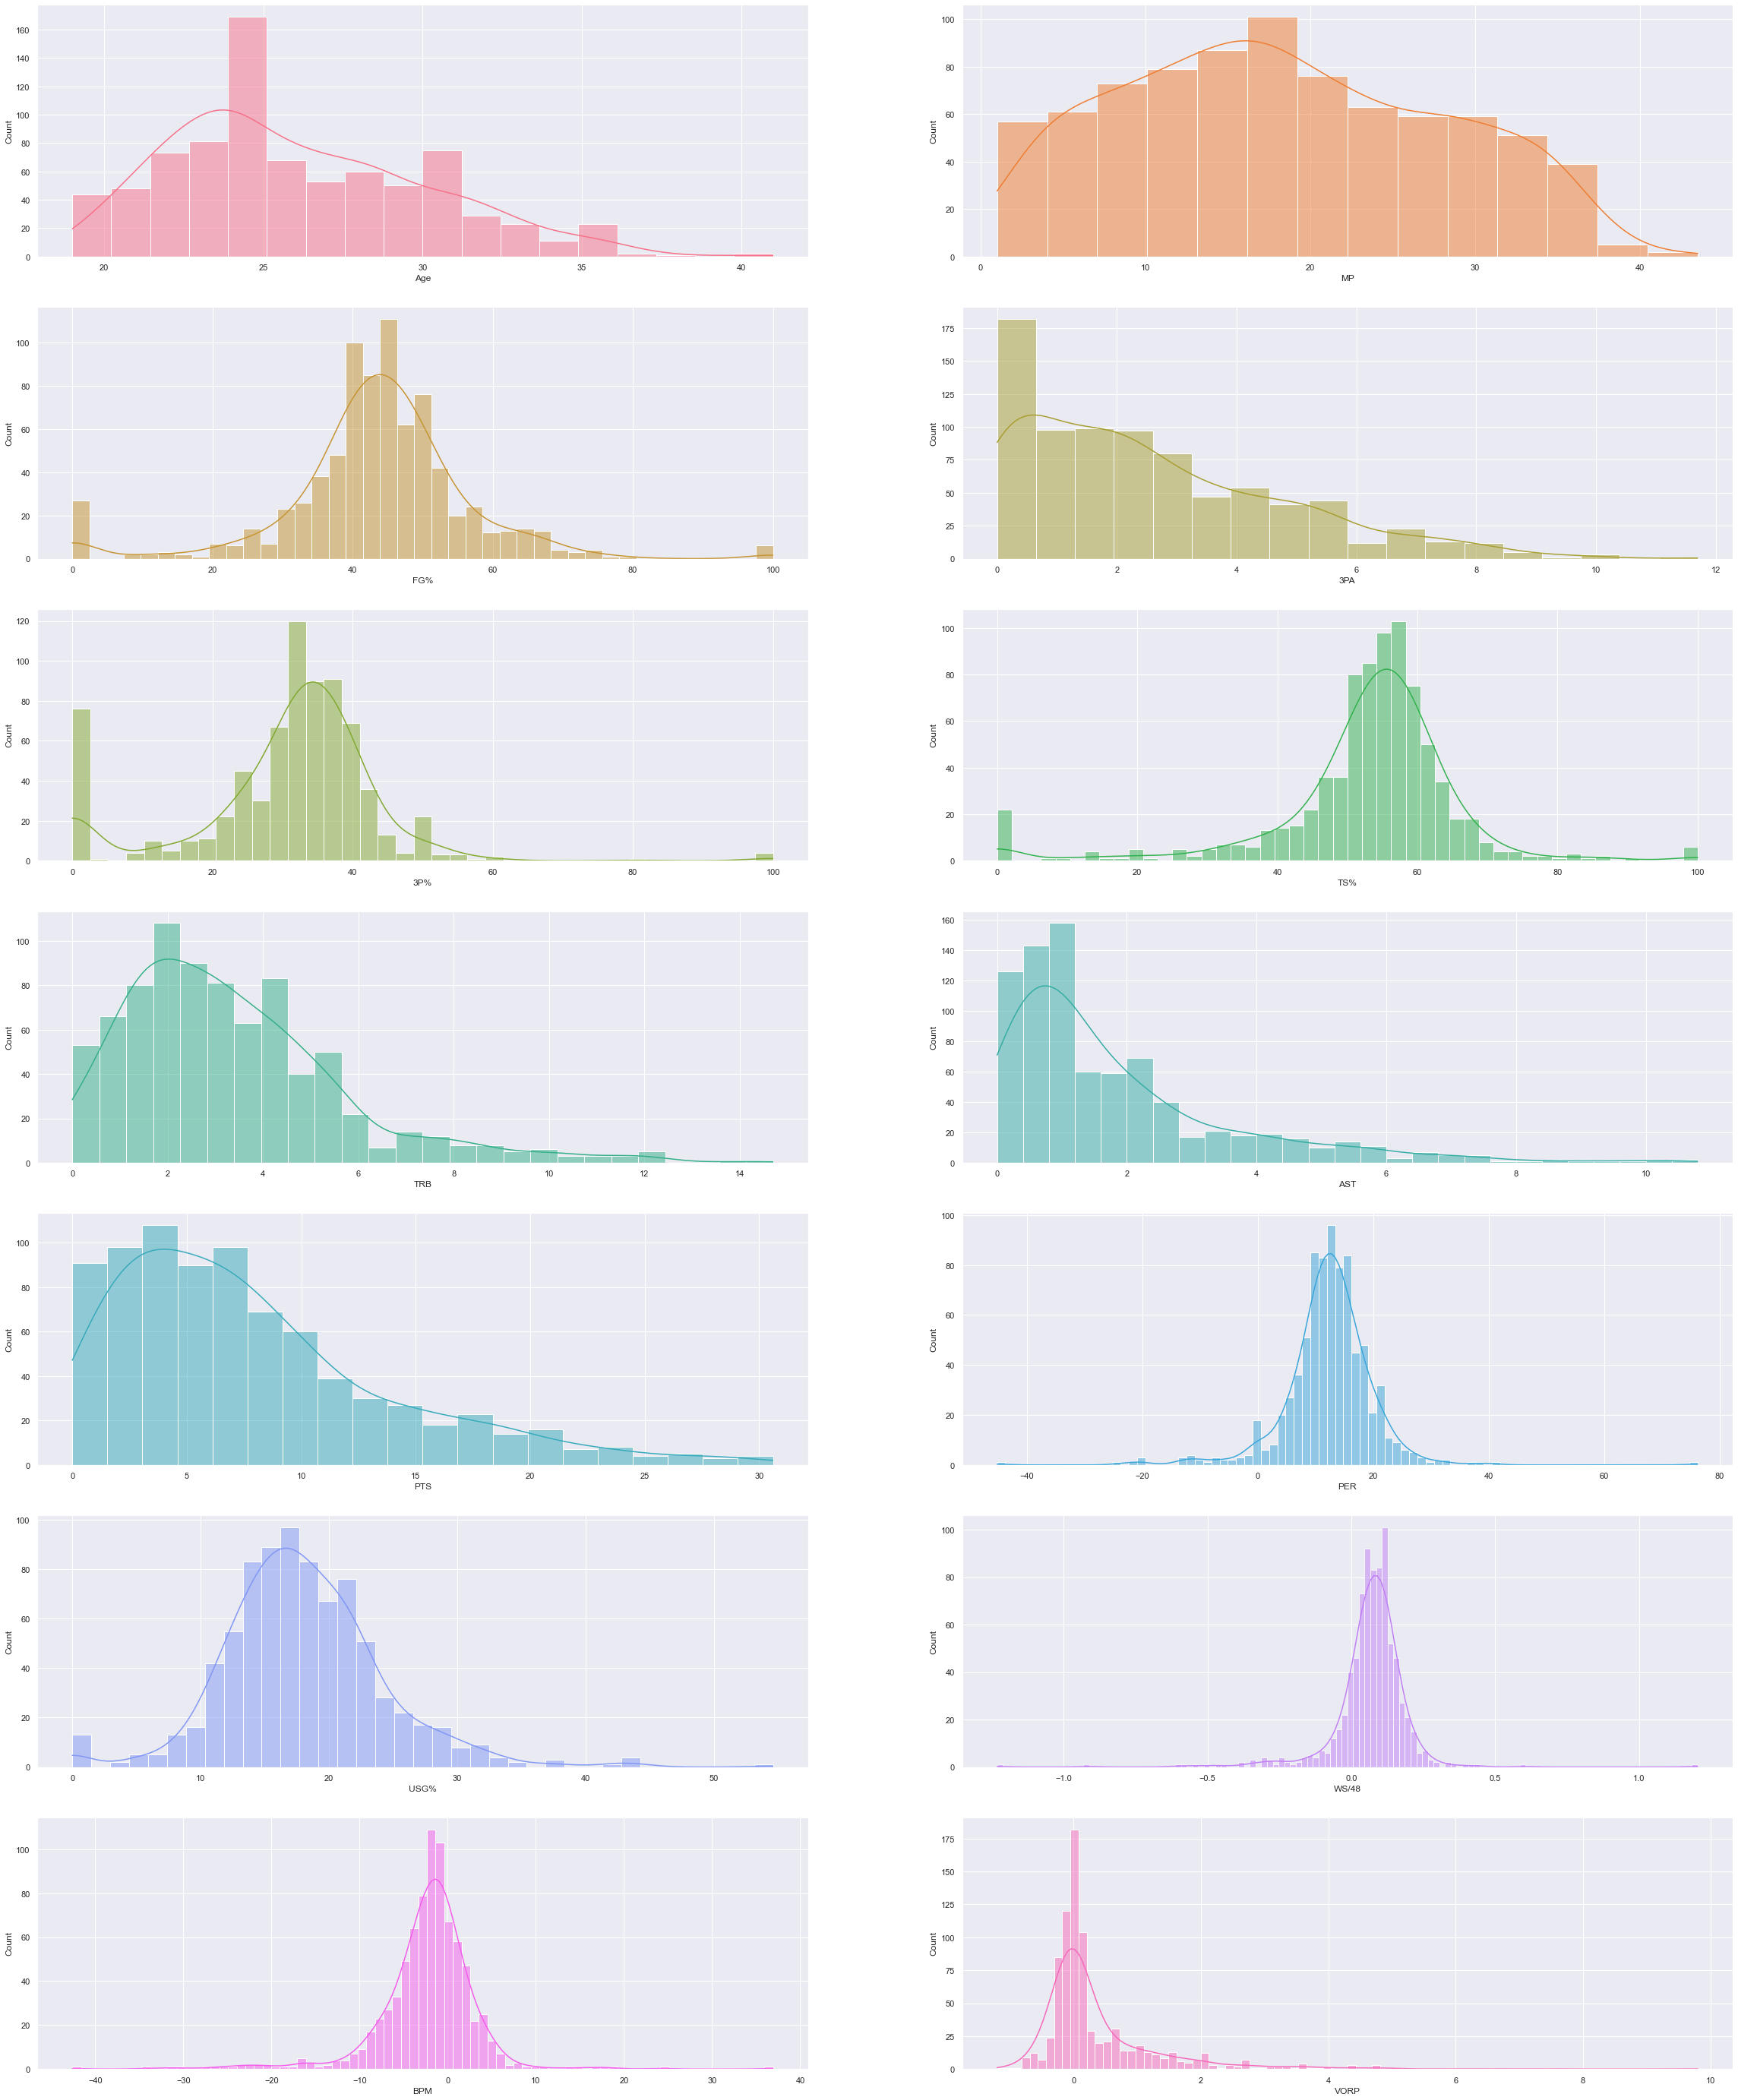

In [5]:
## Analysis 1 : General data overview and trying to uncover interesting patterns

# First, we need to turn the statistical columns into numeric ones 
cols = nba_df_final.columns.drop(['Player','Position','Tm'])
nba_df_final[cols] = nba_df_final[cols].apply(pd.to_numeric)

# Analysis 1: univariate analysis of certain key statistics 
nba_22 = nba_df_final[nba_df_final['Season'] == 2022]

# These are the statistics that I have chosen because of their qualitative impact on outcomes, using my own very biased personal 
# and experience with watching nba games. For me, this set of features is broad and concise enough to give a broad description 
# of the nba landscape while not overwhelming the reader with too many graphics to analyze 

cols = ['Age','MP','FG%', '3PA', '3P%', 'TS%', 'TRB', 'AST', 'PTS', 'PER', 'USG%', 'WS/48', 'BPM', 'VORP']
palette = sns.color_palette('husl', len(cols))
sns.set(style="darkgrid")

fig, axs = plt.subplots(7, 2, figsize=(40, 50))

# Creating a loop to plot all of the chosen statistics 

def col_fct(i): 
    if i%2 == 0: 
        return 0
    else: 
        return 1

def row_fct(i):  
    if i in [0,1]:
        return 0
    else:
        if i%2 ==0: return int(i/2)
        else: return int(i/2-0.5 )
        
for i in range(len(cols)): 
    sns.histplot(data=nba_22, x=cols[i], kde=True, color=palette[i], ax=axs[row_fct(i), col_fct(i)])

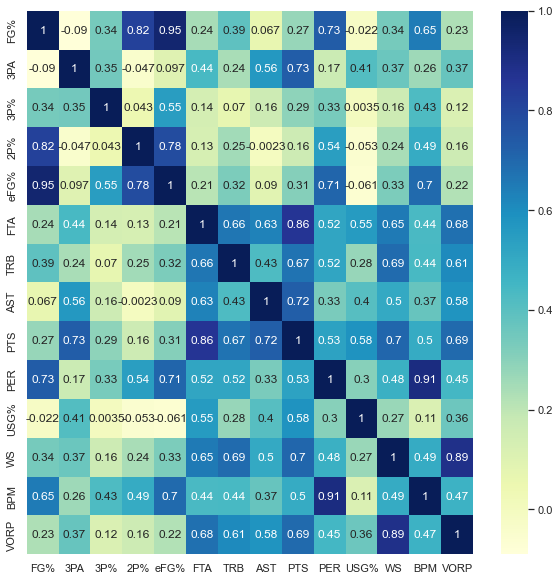

In [6]:
## Creating acorrelation heatmap to inspect relationship between different variables and trying to find non-obvious patterns
## For the sake of visual clarity, I am choosing to select a set of statistics in order to evaluate their relationship

## Takeaways: nothing conclusive that is not already mathematically determinable and common sense, ie. PER being correlated with other
# aggregate efficiency metrics, or 3PA being correlated with assists, which points to a new generation of shooting guards

nba_22.columns
cols = ['FG%', '3PA','3P%', '2P%', 'eFG%', 'FTA', 'TRB', 'AST', 'PTS', 'PER', 'USG%', 'WS', 'BPM', 'VORP']
corr_df = nba_22[cols]


fig2 = plt.figure(figsize =(10,10))
dataplot = sns.heatmap(corr_df.corr(), cmap="YlGnBu", annot=True)
plt.show()

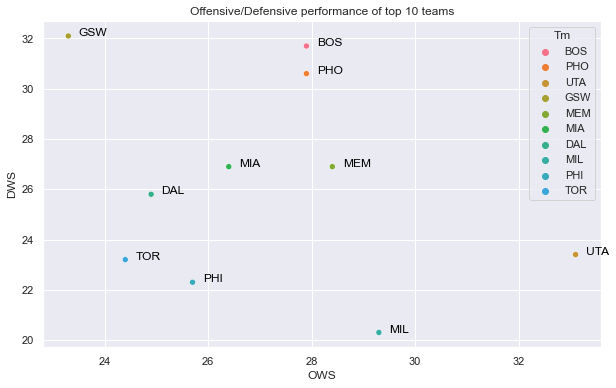

In [7]:
## Ranking the 30 NBA teams across the major statistical categories, which are WS, BPM and VORP

team_ows = nba_22[nba_22['Tm'] != 'TOT'].groupby('Tm')['OWS'].sum().sort_values(ascending=False)
team_ows = pd.DataFrame(team_ows)
team_ows['Rank'] = range(1,len(team_ows)+1)
team_ows

team_dws = nba_22[nba_22['Tm'] != 'TOT'].groupby('Tm')['DWS'].sum().sort_values(ascending=False)
team_dws = pd.DataFrame(team_dws)
team_dws['Rank'] = range(1,len(team_dws)+1)
team_dws

team_ws = nba_22[nba_22['Tm'] != 'TOT'].groupby('Tm')['WS'].sum().sort_values(ascending=False)
team_ws = pd.DataFrame(team_ws)
team_ws['Rank'] = range(1,len(team_ws)+1)
team_ws

team_final = pd.merge(team_ows, team_dws, left_index=True, right_index=True)
team_final['Exp Wins'] = round(team_final['OWS'] + team_final['DWS'])
team_final = team_final.sort_values(by='Exp Wins', ascending=False)
team_final = team_final.rename(columns = {'Rank_x':'Off Rank', 'Rank_y':'Def Rank'})
team_final

# visualizing rankings of top 10 teams 
top_10_teams = team_final[:10]
fig4 = plt.figure(figsize = (10,6))
sns.scatterplot(data=top_10_teams, x='OWS', y='DWS', hue='Tm', palette=palette[:10], sizes=(80,80))
plt.title('Offensive/Defensive performance of top 10 teams')

# label points on the plot 
for x,y,z in zip(top_10_teams['OWS'], top_10_teams['DWS'], top_10_teams.index): 
    plt.text(x=x+0.2, y=y, s=z, color = 'black')
    
## What take-aways can we make? BOS, GSW and UTA appear to have been the best teams 

In [8]:
## In-depth breakdown of scoring 

# Looking at the top scorers, in absolute terms, of the 2022 NBA season 
top_scorers = nba_22.sort_values(by='PTS', ascending=False, ignore_index=True)[['Player','FG%','PTS', 'Position', 'TS%','Age']][:30]
    
# Looking into the positional distribution of top scorers
fig5 = plt.figure(figsize=(8,8))
sns.scatterplot(data=top_scorers, x='FG%',y='PTS', hue = 'Position')
plt.title('PPG positional differences in 2022', color ='blue')
plt.clf()

#Creating age brackets
def age_bracket(x):
    if x<=24: 
        return 'U24'
    elif x<=28: 
        return '24-28'
    elif x<=32: 
        return '28-32'
    else: 
        return 'O32'

top_scorers['Age Group'] = top_scorers.apply(lambda x: age_bracket(x['Age']),axis=1)


# Looking at the age distribution of top scorers
fig6 = plt.figure(figsize=(8,8))
sns.scatterplot(data=top_scorers, x='FG%',y='PTS', hue='Age Group')
plt.title('PPG positional differences in 2022', color ='blue')
plt.clf()

# Looking at the performance of the top 5 scorers
top_scorers_10 = top_scorers[:10]
fig7 = plt.figure(figsize=(10,10))
sns.scatterplot(data=top_scorers_10, x='FG%', y = 'PTS', hue='Position')
plt.legend(loc = 'center right')
plt.title('Plotting the scoring performance of the NBAs best scorers')


for x,y,z in zip(top_scorers_10['FG%'], top_scorers_10['PTS'], top_scorers_10['Player']): 
    plt.text(x=x-0.8, y=y-0.2, s=z, color = 'blue')

plt.clf()



<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 720x720 with 0 Axes>

C:\Users\krist\AppData\Local\Temp\ipykernel_15412\3039620904.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_22['Scoring Rank'] = round(nba_22['PTS'].rank(method='first')/len(nba_22)*100)
C:\Users\krist\AppData\Local\Temp\ipykernel_15412\3039620904.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_22['Assist Rank'] = round(nba_22['AST'].rank(method='first')/len(nba_22)*100)
C:\Users\krist\AppData\Local\Temp\ipykernel_15412\3039620904.py:10: SettingWithCopyWarning: 
A value is trying to be set 

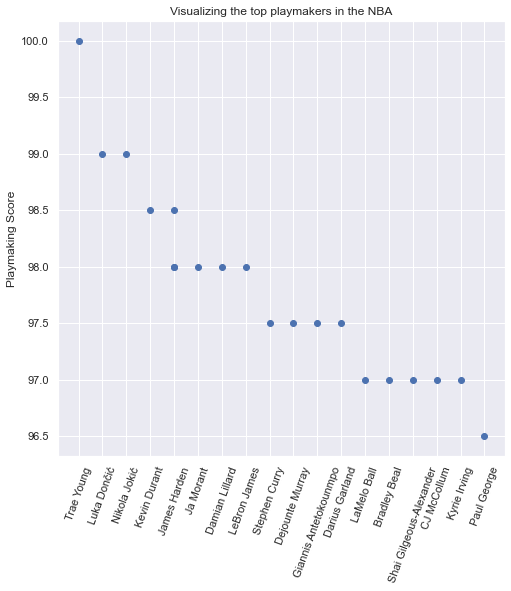

<Figure size 432x288 with 0 Axes>

In [9]:
## In-depth breakdown of playmaking: passing + scoring 

# assigning top quartile performance across the chosen categories of scoring and passing
nba_22['Scoring Rank'] = round(nba_22['PTS'].rank(method='first')/len(nba_22)*100)
nba_22['Assist Rank'] = round(nba_22['AST'].rank(method='first')/len(nba_22)*100)
nba_22.head()

#Finding the top playmakers 
top_playmakers = nba_22[(nba_22['Scoring Rank'] >= 95.0) & (nba_22['Assist Rank'] >= 95.0)]
top_playmakers['Playmaking Score'] = (top_playmakers['Scoring Rank'] + top_playmakers['Assist Rank'])/2
top_playmakers = top_playmakers.sort_values(by='Playmaking Score', ascending =False)

#Visualizing the top playmakers using a simple plt plot 
fig8 = plt.figure(figsize=(8,8))
plt.plot('Player','Playmaking Score', 'ob', data = top_playmakers[:20])
plt.ylabel('Playmaking Score')
plt.title('Visualizing the top playmakers in the NBA')
plt.xticks(rotation=70)
plt.show()
plt.clf()


C:\Users\krist\AppData\Local\Temp\ipykernel_15412\1503638920.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_22['3P% Rank'] = round(nba_22['3P%'].rank(method='first')/len(nba_22)*100)
C:\Users\krist\AppData\Local\Temp\ipykernel_15412\1503638920.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_22['3PA Rank'] = round(nba_22['3PA'].rank(method='first')/len(nba_22)*100)
C:\Users\krist\AppData\Local\Temp\ipykernel_15412\1503638920.py:11: SettingWithCopyWarning: 
A value is trying to be set on a co

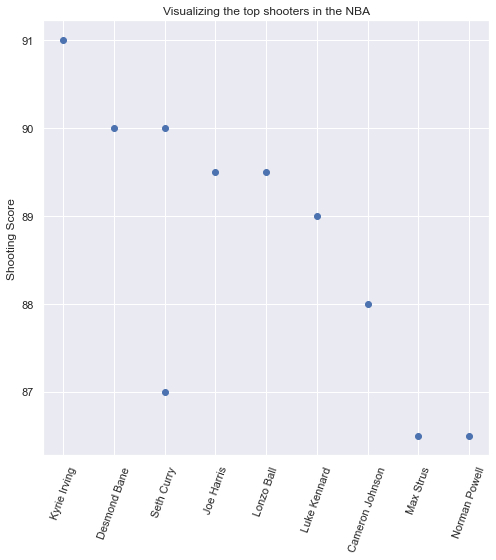

<Figure size 432x288 with 0 Axes>

In [10]:
## In-depth breakdown of three-point shooting: volume and efficiency 

# Let's see who are the best shooting in the NBA 

# assigning top quartile performance across the chosen categories of scoring and passing
nba_22['3P% Rank'] = round(nba_22['3P%'].rank(method='first')/len(nba_22)*100)
nba_22['3PA Rank'] = round(nba_22['3PA'].rank(method='first')/len(nba_22)*100)

#Finding the top playmakers 
top_shooters = nba_22[(nba_22['3P% Rank'] >= 80.0) & (nba_22['3PA Rank'] >= 80.0)]
top_shooters['Shooting Score'] = (top_shooters['3P% Rank'] + top_shooters['3PA Rank'])/2
top_shooters = top_shooters.sort_values(by='Shooting Score', ascending =False)

#Visualizing the top playmakers using a simple plt plot 
fig9 = plt.figure(figsize=(8,8))
plt.plot('Player','Shooting Score', 'ob', data = top_shooters[:10])
plt.ylabel('Shooting Score')
plt.title('Visualizing the top shooters in the NBA')
plt.xticks(rotation=70)
plt.show()
plt.clf()

C:\Users\krist\AppData\Local\Temp\ipykernel_15412\222295708.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_22['DWS Rank'] = round(nba_22['DWS'].rank(method='first')/len(nba_22)*100)
C:\Users\krist\AppData\Local\Temp\ipykernel_15412\222295708.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_22['DBPM Rank'] = round(nba_22['DBPM'].rank(method='first')/len(nba_22)*100)
C:\Users\krist\AppData\Local\Temp\ipykernel_15412\222295708.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy

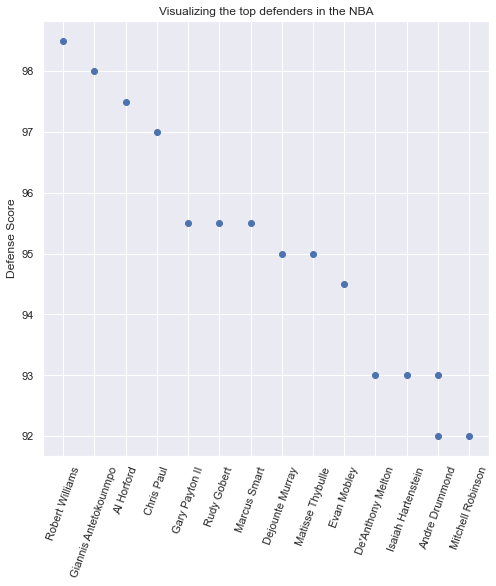

<Figure size 432x288 with 0 Axes>

In [23]:
## In-depth breakdown of the league's best defenders 

# assigning top decile performance across the chosen categories of defense, which are DWS and DBPM
nba_22['DWS Rank'] = round(nba_22['DWS'].rank(method='first')/len(nba_22)*100)
nba_22['DBPM Rank'] = round(nba_22['DBPM'].rank(method='first')/len(nba_22)*100)
nba_22['STL% Rank'] = round(nba_22['STL%'].rank(method='first')/len(nba_22)*100)
nba_22['BLK% Rank'] = round(nba_22['BLK%'].rank(method='first')/len(nba_22)*100)

#Finding the top defenders in the league  
top_defenders = nba_22[(nba_22['DWS Rank'] >= 80.0) & (nba_22['DBPM Rank'] >= 80.0) & ((nba_22['STL% Rank'] >= 90.0)|(nba_22['BLK% Rank'] >= 90.0))]
top_defenders['Defense Score'] = (top_defenders['DWS Rank'] + top_defenders['DBPM Rank'])/2
top_defenders = top_defenders.sort_values(by='Defense Score', ascending =False)
top_defenders[:10]

#Visualizing the top defenders using a simple plt plot 
fig10 = plt.figure(figsize=(8,8))
plt.plot('Player','Defense Score', 'ob', data = top_defenders[:15])
plt.ylabel('Defense Score')
plt.title('Visualizing the top defenders in the NBA')
plt.xticks(rotation=70)
plt.show()
plt.clf()



C:\Users\krist\AppData\Local\Temp\ipykernel_15412\3789404469.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_22['PER Rank'] = round(nba_22['PER'].rank(method='first')/len(nba_22)*100)
C:\Users\krist\AppData\Local\Temp\ipykernel_15412\3789404469.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_22['BPM Rank'] = round(nba_22['BPM'].rank(method='first')/len(nba_22)*100)
C:\Users\krist\AppData\Local\Temp\ipykernel_15412\3789404469.py:6: SettingWithCopyWarning: 
A value is trying to be set on a cop

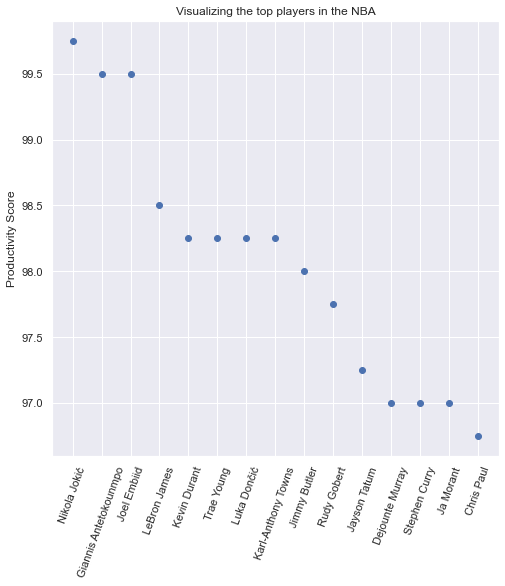

<Figure size 432x288 with 0 Axes>

In [27]:
## In-depth breakdown of the league's most productive players, using aggregate statistics such as PER, BPM, WS and VORP 

# assigning top decile performance across the chosen categories of defense, which are DWS and DBPM
nba_22['PER Rank'] = round(nba_22['PER'].rank(method='first')/len(nba_22)*100)
nba_22['BPM Rank'] = round(nba_22['BPM'].rank(method='first')/len(nba_22)*100)
nba_22['WS Rank'] = round(nba_22['WS'].rank(method='first')/len(nba_22)*100)
nba_22['VORP Rank'] = round(nba_22['VORP'].rank(method='first')/len(nba_22)*100)

#Finding the top defenders in the league  
top_players = nba_22[(nba_22['PER Rank'] >= 80.0) & (nba_22['BPM Rank'] >= 80.0) & (nba_22['WS Rank'] >= 80.0) & (nba_22['VORP Rank'] >= 80.0) & (nba_22['MP'] >= 32.0)]
top_players['Productivity Score'] = (top_players['PER Rank'] + top_players['BPM Rank'] + top_players['WS Rank'] + top_players['VORP Rank'])/4
top_players = top_players.sort_values(by='Productivity Score', ascending =False)

#Visualizing the top defenders using a simple plt plot 
fig11 = plt.figure(figsize=(8,8))
plt.plot('Player','Productivity Score', 'ob', data = top_players[:15])
plt.ylabel('Productivity Score')
plt.title('Visualizing the top players in the NBA')
plt.xticks(rotation=70)
plt.show()
plt.clf()
